![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Implementing Regularised Wasserstein Barycenter problem using JuMP in Julia.


The goal of this notebook is to implement a model to calculate the Wasserstein barycenter by solving an entropy regularised minimization problem in Julia with JuMP and then solve it using MosekTools. For additional info about the data used, theoretical explanation of the calculation of barycenters, references and for more insight in construction of the model, please consult the corresponding [Python notebook](https://nbviewer.jupyter.org/github/MOSEK/Tutorials/blob/master/wasserstein/wasserstein-bary-reg.ipynb). Data files can be found in http://yann.lecun.com/exdb/mnist/.

In [1]:
using LinearAlgebra
using Plots
pyplot()

using JuMP

using Mosek
using MosekTools

using Statistics

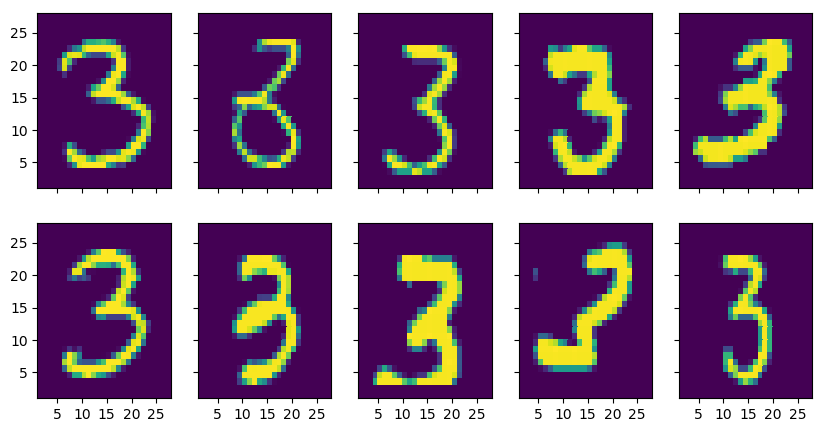

In [2]:
#Define the number of images for the barycenter calculation.
n = 2

#Read the images from the file.
function read_idx(filename)
    f = open(filename,"r")
    data_layout = zeros(UInt8,4)
    readbytes!(f,data_layout,4)
    data_zero = reinterpret(UInt16,data_layout[1:2])
    data_type,data_dimensions = reinterpret(UInt8,data_layout[3:4])
    data_shape = Int32[]
    for i = 1:data_layout[4]
        s = zeros(UInt8,4)
        readbytes!(f,s,4)
        s = map(hton,reinterpret(Int32,s))
        push!(data_shape,s[1])
    end
    idx_data = zeros(UInt8,cumprod(data_shape)[length(data_shape)])
    read!(f,idx_data)
    idx_data = reshape(idx_data,Tuple(reverse(data_shape)))
    return(idx_data)
end

data = read_idx("train-images-idx3-ubyte")
labels = read_idx("train-labels-idx1-ubyte")

#Select the images.
mask = labels .== 3
train_ones = data[:,:,mask]
train = train_ones[:,:,1:n]

x = [i for i=1:28]
y = reverse(x)
f,ax = PyPlot.plt.subplots(2,5,sharey=true,sharex=true,figsize=(10,5))
PyPlot.plt.xticks([5,10,15,20,25])

for i = 1:10
    rand_pick = rand(1:size(train_ones)[3])
    ax[i].pcolormesh(x,y,transpose(train_ones[:,:,rand_pick]))
end

In [3]:
function single_pmf(data)
    #Takes a list of images and extracts the probability mass function.
    v = vec(data[:,:,1])
    v = v./cumsum(v)[length(v)]
    for im_k in 2:size(data)[3]
        image = data[:,:,im_k]
        arr = vec(image)
        v_size = size(arr)[1]
        v = hcat(v, arr./cumsum(arr)[length(arr)])
    end
    return v,size(v)[1]
end

function ms_distance(m,n)
    #Squared Euclidean distance calculation between the pixels.
    d = ones(m,m)
    coor_I = []
    for c_i in 1:n
        append!(coor_I,ones(Int,n).*c_i)
    end    
    coor_J = repeat(1:n,n)
    coor = hcat(coor_I,coor_J)
    for i in 1:m
        for j in 1:m
            d[i,j] = norm(coor[i,:]-coor[j,:]).^2
        end
    end
    return d
end

function reg_wasserstein_barycenter(data,lambda,relgap)
    #Calculation of wasserstein barycenter by solving an entropy regularised minimization problem.
    #Direct mode model
    #M = direct_model(Mosek.Optimizer(MSK_DPAR_INTPNT_CO_TOL_REL_GAP=relgap))
    
    #Automatic mode model
    M = Model(with_optimizer(Mosek.Optimizer,MSK_DPAR_INTPNT_CO_TOL_REL_GAP=relgap))
    
    if length(size(data))==3
        K = size(data)[3]
    else
        K = 1
    end
    v,N = single_pmf(data)
    d = ms_distance(N,size(data)[2])
    
    if lambda==nothing
        lambda = 60/median(vec(d))
    end
    
    #Define indices
    M_i = 1:N
    M_j = 1:N
    M_k = 1:K

    #Adding variables
    M_pi = @variable(M, M_pi[i = M_i, j = M_j, k = M_k] >= 0.0)
    M_mu = @variable(M, M_mu[i = M_i] >= 0.0)

    #Auxiliary variable for the conic constraint
    M_aux = @variable(M,M_aux[i = M_i, j = M_j, k = M_k])
    
    #Adding constraints
    @constraint(M, c3_expr[k = M_k, j = M_j], sum(M_pi[:,j,k]) == v[j,k])
    @constraint(M, c2_expr[k = M_k, i = M_i], sum(M_pi[i,:,k]) == M_mu[i])
    
    #Adding conic constraint
    @constraint(M,cExp_cone[i=M_i, j=M_j, k=M_k],[M_aux[i,j,k],M_pi[i,j,k],1] in MOI.ExponentialCone())
    
    #Non-linear objective in the case of Regularized barycenters.
    W_obj = @objective(M, Min,(sum(d[i,j]*M_pi[i,j,k] for i=M_i,j=M_j,k=M_k) - 
            sum(M_aux[i,j,k] for i=M_i,j=M_j,k=M_k)/lambda)/K)
                    
    return M,M_mu
end

reg_wasserstein_barycenter (generic function with 1 method)

In [4]:
function run_regularised_model(data,lambda=nothing,relgap=1e-7)
    @time begin
        M,M_mu = reg_wasserstein_barycenter(data,lambda,relgap)
        optimize!(M)
    end
    println("Solution status = ",termination_status(M))
    println("Primal objective value = ",objective_value(M))
    mu_level = value.(M_mu)
    return mu_level
end

function show_barycenter(bary_center)
    bary_center = reshape(bary_center,(28,28))
    x = [i for i=1:28]
    y = reverse(x)
    PyPlot.plt.pcolormesh(x,y,transpose(bary_center))
    PyPlot.plt.title("Regularized Barycenter")
    PyPlot.plt.show()
end

show_barycenter (generic function with 1 method)

In [5]:
bary_center = run_regularised_model(train)
println("******")

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3691072         
  Cones                  : 1229312         
  Scalar variables       : 6147344         
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 1.02            
Lin. dep.  - number                 : 1               
Presolve terminated. Time: 7.65    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

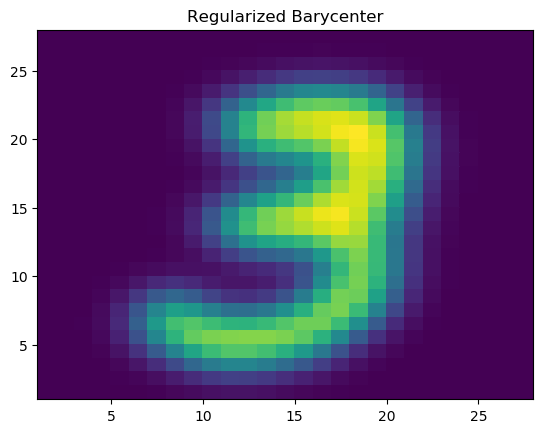

In [6]:
show_barycenter(bary_center)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** is not guaranteed. For more information contact our [support](mailto:support@mosek.com). 